In [1]:
import numpy as np
import torch
import os
import sys
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.data import DataLoader

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path+"/models")
sys.path.append(module_path+"/train")
sys.path.append(module_path+"/datasets")

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [3]:
from datasets import train_test_random_split, load_dsprites, CustomDSpritesDatasetFactorVAE
from train import train_beta_vae, test_beta_vae
from loss import loss_beta_vae
from beta_vae import BetaVAEDSprites, Classifier
from utils import latent_transversal, load_checkpoint, save_checkpoint
from entanglement_metric import entanglement_metric_factor_vae, entanglement_metric_beta_vae

In [4]:
whole_dataset = load_dsprites("../datasets/dsprites.npz", False)
dataset = whole_dataset['imgs']
dataset = torch.from_numpy(dataset)

In [20]:
np.random.seed(2)
torch.manual_seed(2)
random.seed(2)

In [29]:
data_size = 10000
data_ = CustomDSpritesDatasetFactorVAE(whole_dataset, data_size)

In [15]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-2)

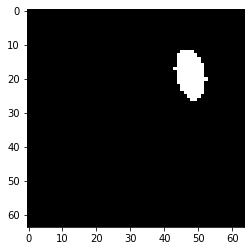

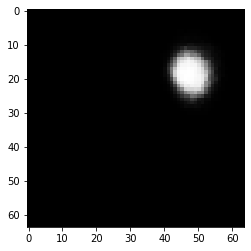

In [30]:
index = 100
original = dataset[index].float().to(device)
recon, mu, logvar = model(original)
plt.imshow(original.cpu(), cmap='Greys_r')
plt.show()
plt.imshow(torch.sigmoid(recon.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()

In [5]:
def compute_latent_gaussian_variance(model, dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=True)
    accumulator = torch.zeros(10)
    with torch.no_grad():
        for index, data in enumerate(loader):
            # shape of data is 64 x img_size
            _, _, logvar = model(data.float())
            accumulator = accumulator + logvar.div(2).exp().sum(0)
            if index % 1000 == 999:
                print('.', end='')
            del logvar
    return accumulator.div(len(dataset))

In [6]:
def plot_loss(loss_list, title):
    plt.plot(np.arange(1,len(loss_list)+1, 1), loss_list)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training "+title)
    plt.show()

## base model, beta vae with beta=1

In [11]:
model_beta1_e50_alldata_n = BetaVAEDSprites()
optimizer = torch.optim.Adagrad(model_beta1_e50_alldata_n.parameters(), lr=1e-2)
start_epoch = 0 
losslogger = []

In [12]:
model_beta1_e50_alldata_n, optimizer, start_epoch, losslogger = load_checkpoint(model_beta1_e50_alldata_n, 
    optimizer, losslogger, 
    filename='trained_models/betavae_beta1_e50_alldata_n.pth.tar')
model_beta1_e50_alldata_n.eval()

=> loading checkpoint 'trained_models/betavae_beta1_e50_alldata_n.pth.tar'
=> loaded checkpoint 'trained_models/betavae_beta1_e50_alldata_n.pth.tar' (epoch 51)


BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [15]:
losses = [loss for sublist in losslogger for loss in sublist]
print(losses)

[(125.77099225835667, 105.86518495861027), (92.08709050880537, 73.99835826084018), (85.2722313967016, 67.04719715524051), (80.81334857891004, 62.170928330057194), (77.22119611087773, 58.26474257558584), (74.68398270383477, 55.52059635395805), (72.74855619213648, 53.428381871845986), (71.15486820911367, 51.70470070300831), (69.77306244646509, 50.21949276286695), (68.55559150874615, 48.90293678227398), (67.45463773690992, 47.71896530687809), (66.43931341543794, 46.633695835040676), (65.53230361019571, 45.64913778627912), (64.68834607551496, 44.735274040450655), (63.90645095705986, 43.89594757598307), (63.1853914099435, 43.111758605887495), (62.515755631443525, 42.38944301754236), (61.8825933403439, 41.70714761482345), (61.301035605371, 41.079138062066505), (60.75621951123079, 40.486437409702276), (60.24063700478938, 39.926704643501175), (59.76539100747969, 39.40441779813005), (59.31400863370962, 38.91368216338257), (58.88881354323692, 38.44926497733427), (58.47497467075785, 38.0065983328

In [17]:
np.save('trained_models/betavae_beta1_e50_n_losses.npy', losses)

In [22]:
torch.save(model_beta1_e50_alldata_n, 'trained_models/betavae_beta1_e50_n.dat')

In [18]:
model_beta1_e50_alldata_n.cpu()

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

accuracies : [0.5800000000000001]
[[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  9.  0.  6.  4.  0.  5.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0. 13.  0.  0.]
  [ 6.  0.  4.  0.  0.  0.  3.  1.  5.  2.]
  [ 6.  0.  0.  0.  4.  0.  4.  0.  3.  0.]
  [ 0.  0.  0.  0. 24.  0.  1.  0.  0.  0.]]]
Factor Vae metric: 
Accuracy: 0.5800000000000001
Beta Vae metric: 


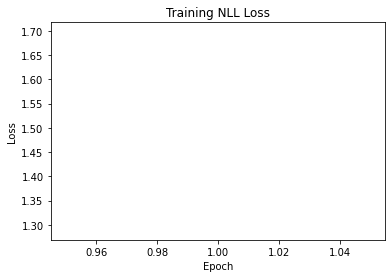

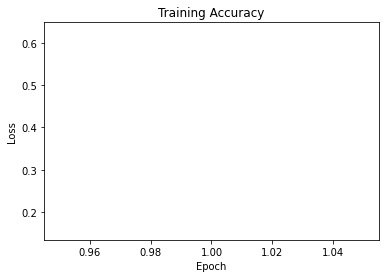

In [33]:
loss = entanglement_metric_factor_vae(model_beta1_e50_alldata_n, data_, 100, 1000)
print("Factor Vae metric: ")
print("Accuracy: "+str(1-loss))
print("Beta Vae metric: ")
classifier = Classifier()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
losses, accuracies, test_accuracy = entanglement_metric_beta_vae(model_beta1_e50_alldata_n, 
    classifier, optimizer, 1000,  data_, 500, 50, random_seeds=1)


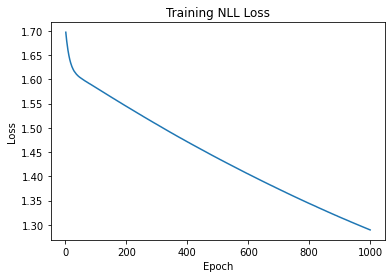

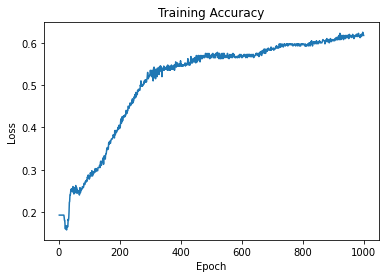

0.56


In [36]:
plot_loss(losses[0], "NLL Loss")
plot_loss(accuracies[0], "Accuracy")
print(test_accuracy)

In [37]:
latent_gaussian_variance_beta1 = compute_latent_gaussian_variance(model_beta1_e50_alldata_n, dataset)
print(latent_gaussian_variance_beta1)

...........tensor([0.0514, 0.9818, 0.1145, 0.9793, 0.0236, 0.1030, 0.0533, 0.0572, 0.0401,
        0.9770])


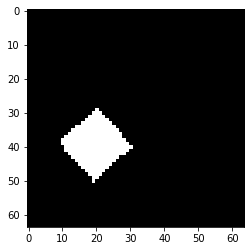

In [24]:
index = np.random.randint(0, len(dataset))
original = dataset[index].float()
plt.imshow(torch.sigmoid(original.detach()).view(64,64), cmap='Greys_r')
plt.show()

In [25]:
recon, mu, logvar = model_beta1_e40_alldata_n(original)

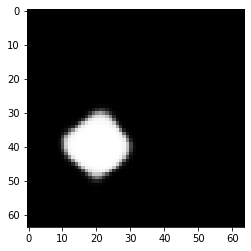

In [26]:
plt.imshow(torch.sigmoid(recon.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()

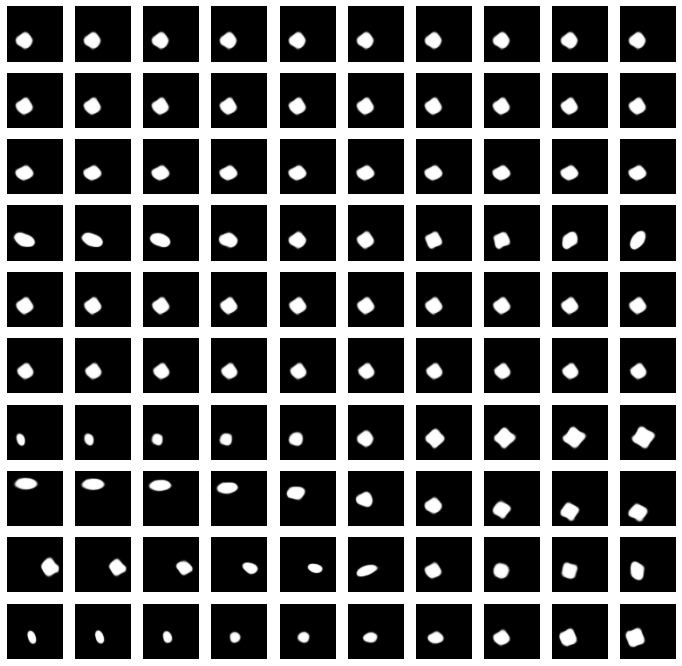

In [27]:
fig = plt.figure(figsize=[12, 12])
for i in range(10):
    imgs = latent_transversal(model_beta1_e40_alldata_n, original, -3, 3, 10, i)
    for j, img in enumerate(imgs):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.axis('off')
        plt.imshow(torch.sigmoid(img.detach()).view(64,64), cmap='Greys_r')
plt.show()

# Beta VAE with beta=4

In [24]:
model_beta4_e50 = BetaVAEDSprites()
optimizer = torch.optim.Adagrad(model_beta4_e50.parameters(), lr=1e-2)
start_epoch = 0 
losslogger = []

In [25]:
model_beta4_e50, optimizer, start_epoch, losslogger = load_checkpoint(model_beta4_e50, 
    optimizer, losslogger, 
    filename='trained_models/betavae_beta4_e50_alldata_n.pth.tar')
model_beta4_e50.eval()
model_beta4_e50.cpu()

=> loading checkpoint 'trained_models/betavae_beta4_e50_alldata_n.pth.tar'
=> loaded checkpoint 'trained_models/betavae_beta4_e50_alldata_n.pth.tar' (epoch 51)


BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [26]:
losses = [loss for sublist in losslogger for loss in sublist]
print(losses)

[(162.65930790785285, 121.43632822566562), (135.9103525330623, 97.74196962763865), (133.90409303290977, 95.47274134970374), (132.9312772270706, 94.38940346406565), (132.23184969772896, 93.65343622201019), (131.67990557435485, 93.0656863939431), (131.1949344062143, 92.52207903729544), (130.7413678823246, 91.98074556556013), (130.2219895877772, 91.39187795006566), (129.70359932714038, 90.74366967131694), (129.156271075209, 90.0611795079377), (128.5758259503378, 89.35012087888188), (127.74165867931313, 88.12393816394939), (125.66939431760046, 84.92417981889513), (123.11340160171191, 81.28471932311852), (121.02867811587122, 78.45397950543298), (119.67968965073426, 76.73323442662756), (118.8175570997927, 75.5788965895772), (118.09960926324129, 74.66163469933801), (117.4885237697098, 73.89843635261059), (116.94373370955388, 73.1918537836108), (116.4296163527502, 72.49697393634253), (115.8641716308064, 71.77498089977436), (115.27890132947101, 71.03555654568805), (114.69356196456485, 70.275051

In [38]:
loss = entanglement_metric_factor_vae(model_beta4_e50, data_, 100, 1000)
print("Factor Vae metric: ")
print("Accuracy: "+str(1-loss))
print("Beta Vae metric: ")
classifier = Classifier()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
losses, accuracies, test_accuracy = entanglement_metric_beta_vae(model_beta4_e50, 
    classifier, optimizer, 1000,  data_, 500, 50, random_seeds=1)


accuracies : [0.8]
[[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0. 10.  0.  0.  8.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0. 23.  0.  0.  0.]
  [ 1.  0.  0. 17.  0.  2.  0.  0.  0.  9.]
  [ 0.  0.  0.  0.  0.  0.  0.  0. 12.  0.]
  [ 0.  0.  0.  0.  0.  0.  0. 18.  0.  0.]]]
Factor Vae metric: 
Accuracy: 0.8
Beta Vae metric: 


In [44]:
accuracies[0][-1]

0.8025

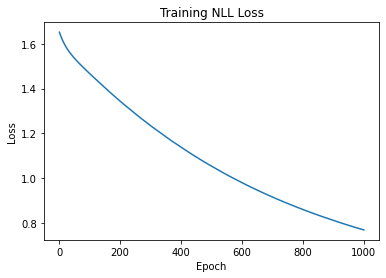

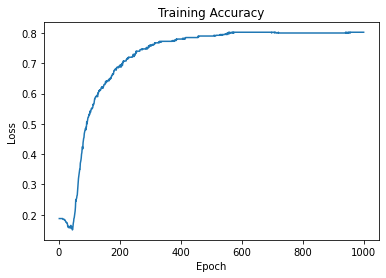

0.8


In [39]:
plot_loss(losses[0], "NLL Loss")
plot_loss(accuracies[0], "Accuracy")
print(test_accuracy)

In [27]:
np.save('trained_models/betavae_beta4_e50_n_losses.npy', losses)

In [28]:
torch.save(model_beta4_e50, 'trained_models/betavae_beta4_e50_n.dat')

In [45]:
latent_gaussian_variance_beta4 = compute_latent_gaussian_variance(model_beta4_e50, dataset)

...........

In [46]:
print(latent_gaussian_variance_beta4)

tensor([0.9948, 0.9937, 0.9945, 0.2888, 0.9963, 0.9922, 0.1115, 0.0404, 0.0636,
        0.1859])


In [48]:
index = np.random.randint(0, len(dataset))
original = dataset[index].float()


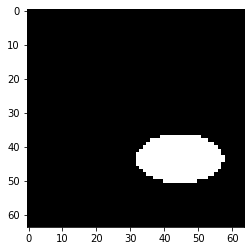

In [49]:
plt.imshow(torch.sigmoid(original.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()

In [51]:
recon, mu, logvar = model_beta4_e50(original)

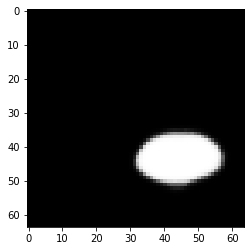

In [52]:
plt.imshow(torch.sigmoid(recon.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()

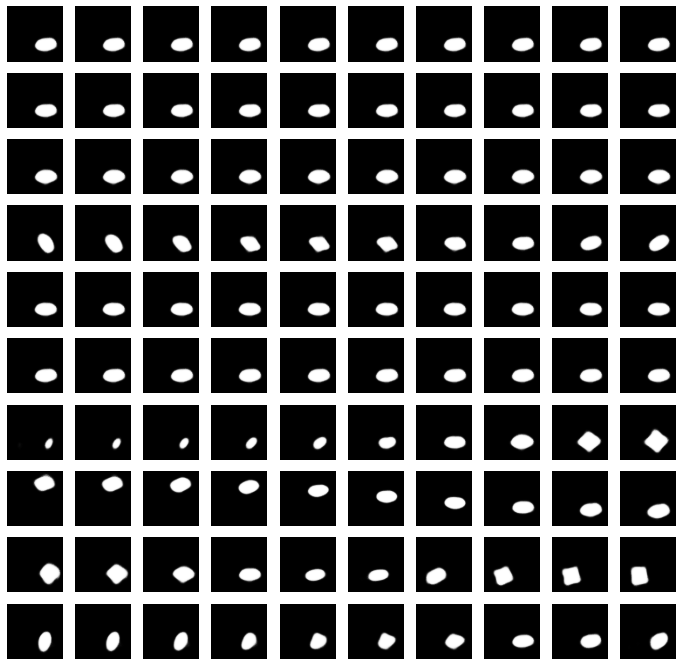

In [54]:
fig = plt.figure(figsize=[12, 12])
for i in range(10):
    imgs = latent_transversal(model_beta4_e50, original, -3, 3, 10, i)
    for j, img in enumerate(imgs):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.axis('off')
        plt.imshow(torch.sigmoid(img.detach()).view(64,64), cmap='Greys_r')
plt.show()

In [9]:
model = BetaVAEDSprites()
model.to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-2)
losslogger = []

In [11]:
model_beta4_e100, optimizer, start_epoch, losslogger = load_checkpoint(
    model, optimizer, losslogger,
    'trained_models/betavae_beta4_e100_alldata.pth.tar')

=> loading checkpoint 'trained_models/betavae_beta4_e100_alldata.pth.tar'
=> loaded checkpoint 'trained_models/betavae_beta4_e100_alldata.pth.tar' (epoch 101)


In [12]:
model_beta4_e100(dataset[0].float().to(device))

(tensor([[-22.1766, -21.6752, -22.0266,  ..., -22.2811, -22.0703, -21.9393]],
        device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[ 0.6407,  0.3896,  1.2050, -0.0108, -0.7347,  1.5645,  0.0088, -0.5321,
           0.7589, -0.0401]], device='cuda:0', grad_fn=<SliceBackward>),
 tensor([[-5.9687, -4.9327, -6.1625, -0.0626, -6.8360, -7.9847, -0.0889, -8.4066,
          -8.3986, -0.0898]], device='cuda:0', grad_fn=<SliceBackward>))

In [25]:
latent_gaussian_variance_beta4 = compute_latent_gaussian_variance(model_beta4_e100, dataset)
print(latent_gaussian_variance_beta4)

...........tensor([0.0414, 0.0913, 0.0380, 0.9566, 0.0316, 0.0158, 0.9635, 0.0189, 0.0130,
        0.9602])


In [13]:
index = np.random.randint(0, len(dataset))
original = dataset[index].float().to(device)


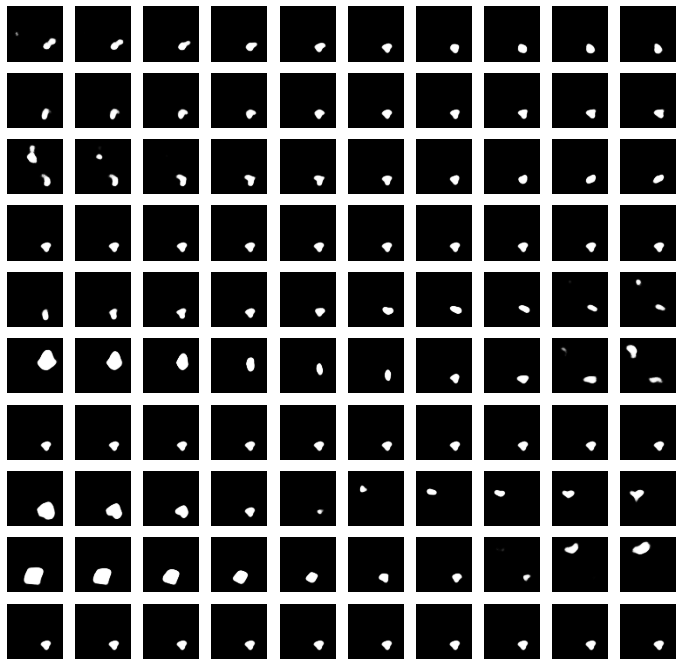

In [14]:
fig = plt.figure(figsize=[12, 12])
for i in range(10):
    imgs = latent_transversal(model, original, -3, 3, 10, i)
    for j, img in enumerate(imgs):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.axis('off')
        plt.imshow(torch.sigmoid(img.detach()).view(64,64), cmap='Greys_r')
plt.show()

In [21]:
model_beta4_e100.cpu()

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 9.  9.  0.  0.  0.  2.  0.  2.  2.  0.]
 [ 0.  4.  6.  3.  0.  0.  1.  0.  0.  3.]
 [14.  1.  0.  0.  4.  0.  0.  0.  5.  0.]
 [ 0.  0.  2.  0.  6.  6.  0.  2.  0.  0.]
 [ 0.  0.  0.  0.  3.  4.  0.  2. 10.  0.]]
Factor Vae metric: 
Accuracy: 0.44999999999999996
Beta Vae metric: 
Epoch 0 finished, loss: 1.6275816917419434, accuracy:0.1925
Epoch 1 finished, loss: 1.626277008652687, accuracy:0.19625
Epoch 2 finished, loss: 1.625090028345585, accuracy:0.19625
Epoch 3 finished, loss: 1.6239756524562836, accuracy:0.19625
Epoch 4 finished, loss: 1.6228930607438088, accuracy:0.19375
Epoch 5 finished, loss: 1.6219044610857964, accuracy:0.195
Epoch 6 finished, loss: 1.6209238588809967, accuracy:0.195
Epoch 7 finished, loss: 1.6200217470526694, accuracy:0.19125
Epoch 8 finished, loss: 1.6191286817193031, accuracy:0.1925
Epoch 9 finished, loss: 1.6182975947856904, accuracy:0.19125
Epoch 10 finished, loss: 1.6175555661320686, accuracy:0.195
Epoch 11 fi

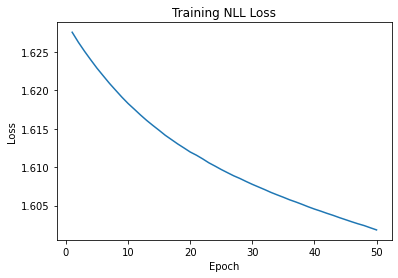

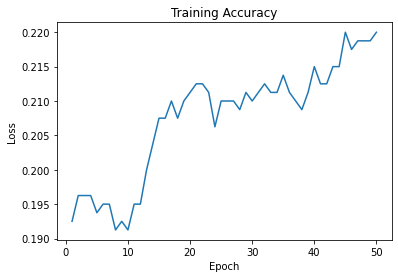

In [24]:
loss = entanglement_metric_factor_vae(model_beta4_e100, data_, 100, 1000)
print("Factor Vae metric: ")
print("Accuracy: "+str(1-loss))
print("Beta Vae metric: ")
classifier = Classifier()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
losses, accuracies = entanglement_metric_beta_vae(model_beta4_e100, classifier, optimizer, 50,  data_, 1000, 10)
plot_loss(losses, "NLL Loss")
plot_loss(accuracies, "Accuracy")

In [27]:
model_beta4_e40_alldata = torch.load('trained_models/betavae_beta4_e40_alldata.dat')
model_beta4_e40_alldata.cpu()

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 16.  8.  0.  3.  0.  0.  0.  0.]
 [ 2.  0.  3.  0.  0. 11.  4.  0.  0.  6.]
 [ 0.  0. 10.  2.  0.  3.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  8.  0.  0.  7.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 16.  0.]]
Factor Vae metric: 
Accuracy: 0.61
Beta Vae metric: 
Epoch 0 finished, loss: 1.6715067833662034, accuracy:0.1725
Epoch 1 finished, loss: 1.667233557999134, accuracy:0.17125
Epoch 2 finished, loss: 1.6632487550377846, accuracy:0.1725
Epoch 3 finished, loss: 1.6594988226890564, accuracy:0.17375
Epoch 4 finished, loss: 1.6559909299015998, accuracy:0.17375
Epoch 5 finished, loss: 1.6527004778385161, accuracy:0.17375
Epoch 6 finished, loss: 1.6496044412255286, accuracy:0.1675
Epoch 7 finished, loss: 1.6466932490468025, accuracy:0.16625
Epoch 8 finished, loss: 1.643994389474392, accuracy:0.16875
Epoch 9 finished, loss: 1.6413757890462874, accuracy:0.1725
Epoch 10 finished, loss: 1.6389542564749717, accuracy:0.1725
Epoch 11 finished, loss

Epoch 131 finished, loss: 1.565345761179924, accuracy:0.3025
Epoch 132 finished, loss: 1.5650042921304703, accuracy:0.30375
Epoch 133 finished, loss: 1.5647007644176483, accuracy:0.30375
Epoch 134 finished, loss: 1.5643965259194375, accuracy:0.305
Epoch 135 finished, loss: 1.5640531063079834, accuracy:0.305
Epoch 136 finished, loss: 1.5637504518032075, accuracy:0.305
Epoch 137 finished, loss: 1.5634283050894737, accuracy:0.305
Epoch 138 finished, loss: 1.563120184838772, accuracy:0.30625
Epoch 139 finished, loss: 1.5627879217267036, accuracy:0.30625
Epoch 140 finished, loss: 1.5624735668301581, accuracy:0.305
Epoch 141 finished, loss: 1.562188918888569, accuracy:0.30375
Epoch 142 finished, loss: 1.5618487000465393, accuracy:0.305
Epoch 143 finished, loss: 1.5615535020828246, accuracy:0.30375
Epoch 144 finished, loss: 1.561227560043335, accuracy:0.30625
Epoch 145 finished, loss: 1.5609609976410865, accuracy:0.30625
Epoch 146 finished, loss: 1.5606245830655099, accuracy:0.30625
Epoch 147

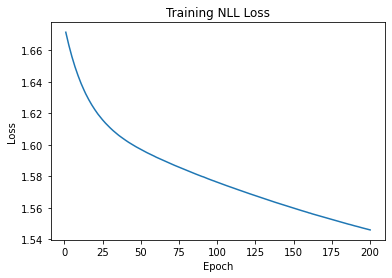

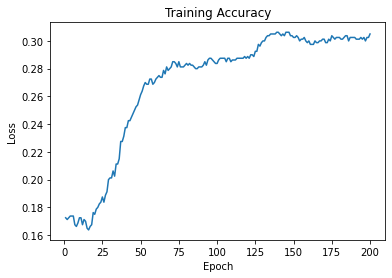

In [29]:
loss = entanglement_metric_factor_vae(model_beta4_e40_alldata, data_, 100, 1000)
print("Factor Vae metric: ")
print("Accuracy: "+str(1-loss))
print("Beta Vae metric: ")
classifier = Classifier()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
losses, accuracies = entanglement_metric_beta_vae(model_beta4_e40_alldata, classifier, optimizer, 200,  data_, 1000, 10)
plot_loss(losses, "NLL Loss")
plot_loss(accuracies, "Accuracy")